# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Цель: построить модель, которая по фотографии определит приблизительный возраст человека.

Решаем задачу регрессии с помощью машинного обучения алгоритмом нейросеть

# Содержание

1. Исследовательский анализ данных
2. Обучение модели
3. Анализ модели

## Исследовательский анализ данных

Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим необходимые данные в датафрейм и переведём в тензоры

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Оценим размер датасета

In [ ]:
labels.shape

(7591, 2)

Изучим данные

In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Итак, в данных 7591 строка и 2 столбца, содержащие фото и реальный возраст человека. Пропусков нет

Построим график распределения возраста и изучим описание данных

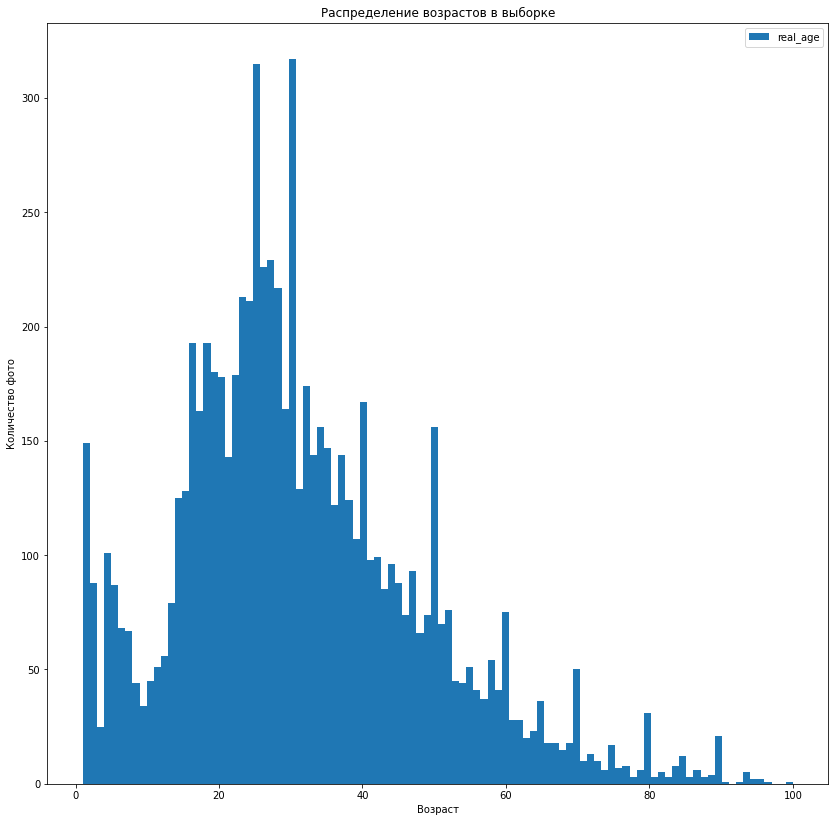

In [ ]:
labels.plot(y='real_age', kind='hist', bins=100, figsize=(14, 14));
plt.title('Распределение возрастов в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество фото')
plt.show()

In [ ]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Исходя из графика и описания, видим, что средний возраст в выборке составляет 31 год. Стандартное отклонение 17 лет, что позволит хорошо обучиться модели на возрасте до совершеннолетия и после. Для наших целей это хороший показатель. Также мы видим на графике пиковые значения возрастов: 25, 30, 40, 50 лет. Это может означать, что при сборе данных был акцент на определённые возрастные категории или датасет собран специальным образом для конкретных задач

Посмотрим, что из себя представляют фото людей в выборке, напечатав часть снимков и сопоставив с реальным возрастом, чтобы оценить разметку датасета

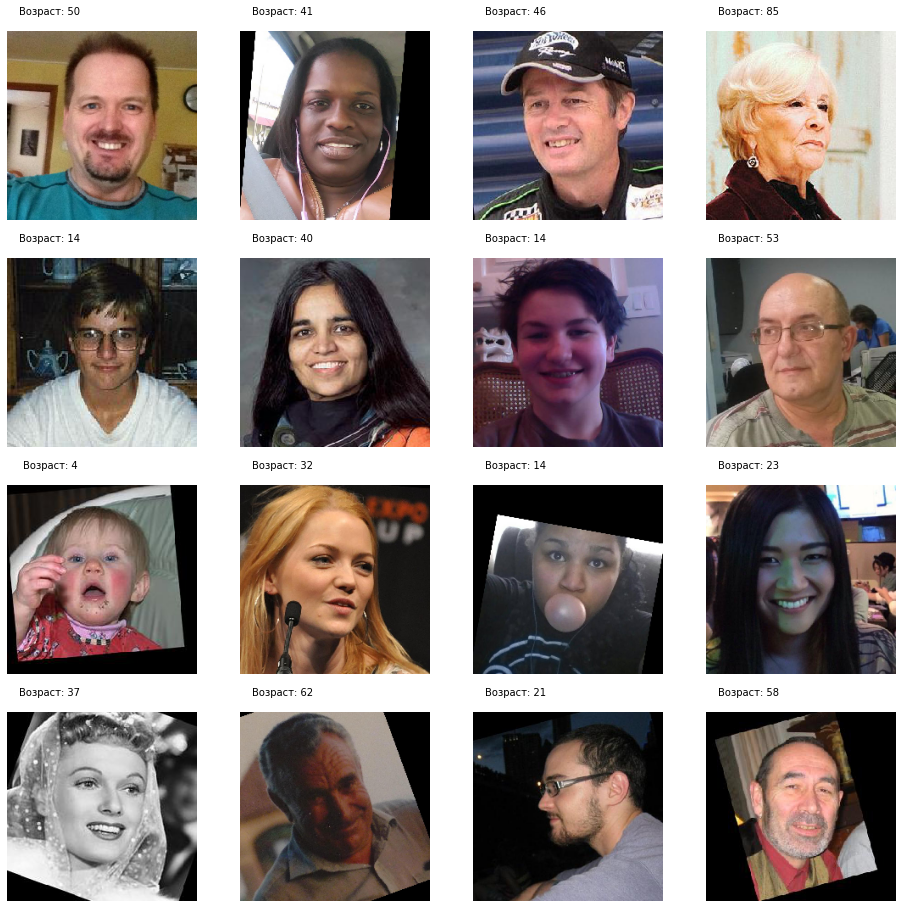

In [ ]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(16,16))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.axis('off')
    plt.text(50, -20, f'Возраст: {target[i]}', fontsize=10, ha='center')
plt.show()

Видим, что есть не идеальные фото, которые тоже необходимы для качественного обучения модели. Также отметим, что разметка реального возраста визуально совпадает с людьми на фото, ошибок не наблюдается. Отметим, что в основном на фото крупный план лица, но есть варианты, где люди стоят на отдалении

Вывод: мы имеем в наличии размеченный датасет с изображениями лиц людей в основном крупным планом. Основную часть датасета составляют люди среднего возраста, что позволит хорошо обучиться модели отличать их от несовершеннолетних, которым нельзя продавать алкоголь. Также отметим, что датасет не очень большой, поэтому на этапе обучения будем применять аугментацию для того, чтобы модель обучилась лучше

## Обучение модели

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       height_shift_range=0.1,
                                       width_shift_range=0.1)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    
    valid_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255)

    valid_datagen_flow = valid_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return valid_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])

    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=12,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/12
2023-07-12 12:54:17.464180: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-12 12:54:17.987114: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 104s - loss: 258.9879 - mae: 11.8119 - val_loss: 720.6585 - val_mae: 21.9042
Epoch 2/12
178/178 - 95s - loss: 112.3588 - mae: 8.0148 - val_loss: 665.8318 - val_mae: 20.8205
Epoch 3/12
178/178 - 90s - loss: 92.2631 - mae: 7.2562 - val_loss: 323.3488 - val_mae: 13.3580
Epoch 4/12
178/178 - 88s - loss: 76.8472 - mae: 6.6443 - val_loss: 154.6653 - val_mae: 9.1927
Epoch 5/12
178/178 - 88s - loss: 68.7136 - mae: 6.3659 - val_loss: 100.5210 - val_mae: 7.6319
Epoch 6/12
178/178 - 87s - loss: 62.3700 - mae: 6.0193 - val_loss: 91.8390 - val_mae: 7.1673
Epoch 7/12
178/178 - 90s - loss: 54.4013 - mae: 5.6335 - val_loss: 76.8256 - val_mae: 6.6207
Epoch 8/12
178/178 - 99s - loss: 51.6744 - mae: 5.4762 - val_loss: 80.5116 - val_mae: 6.5831
Epoch 9/12
178/178 - 100s - loss: 45.2848 - mae: 5.1865 - val_loss: 84.2439 - val_mae: 6.6627
Epoch 10/12
178/178 - 100s - loss: 41.6851 - mae: 4.9872 - val_loss: 86.3894 - val_mae: 6.8033
Epoch 11/12
178/178 - 95s - loss: 38.1017 - mae: 4.7391 - val_loss: 73.6778 - val_mae: 6.3129
Epoch 12/12
178/178 - 95s - loss: 33.8192 - mae: 4.5058 - val_loss: 90.6658 - val_mae: 6.9713
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 90.6658 - mae: 6.9713
Test MAE: 6.9713

```

## Анализ обученной модели

Разработанная модель показывает достаточно точные результаты для определения возрастных категорий. Ошибка в ~7 лет делает её хорошим подспорьем для решения задачи рекомендации товаров определённой возрастной группе.


Однако для решения задачи контроля кассиров при продаже алкоголя модель недостаточно точна и требует доработки. Возможно, стоит расширить набор данных, который будет содержать больше фото возрастных групп, в меньшей степени представленных в имеющемся у нас датасете. Или попробовать улучшить алгоритм.

Итого, нашими задачами для модели определения возраста были:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы - да, модель решает задачу определения возрастной категории;
- Контролировать добросовестность кассиров при продаже алкоголя - нет, модель недостаточно точно определяет возраст конкретного человека, поэтому доверять ей контроль за продажей алкоголя не следует, необходимы доработки